In [26]:
import numpy as np
import pandas as pd
import os, io, random
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import tensorflow as tf
import tensorflow.keras as k
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using memory growth regime.")
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass


Num GPUs Available:  1
Using memory growth regime.


#### Step 1: Creating the gridworld.

In [2]:
# Vector shape per cell = 32:
"""
1 -> R
2 -> G
3 -> B
4 -> Alpha (dead or alive)
5 - 32 -> hidden variables of the cell.
"""

# Image resolution = 256 * 256
# Center the image and put it in the middle of the grid, with active pixels taking up roughly 1/2 of the space (128 * 128)
# Map shape = (256, 256, 32)

HYPERPARAMS = {'min-steps': 0,
               'max-steps': 0,
               'min-backprop-steps': 64,
               'max-backprop-steps': 96,
               'map_width': 60,
               'map_height': 48,
              'cell_vars': 16,
              'kernel_size':(3,3),
              'alive_threshold':0.1}
from tensorflow.keras import layers, optimizers, models
in_ = layers.Input((*HYPERPARAMS['kernel_size'], HYPERPARAMS['cell_vars']))
x = layers.Conv2D(32, kernel_size = HYPERPARAMS['kernel_size'], padding = "same", activation="relu")(in_)
x = layers.Conv2D(64, kernel_size = HYPERPARAMS['kernel_size'], padding = "valid", activation="relu")(in_)

x = layers.Reshape((1, 64))(x)

def layer(x, n=5):
    x = layers.Conv1D(32, kernel_size = n, padding = "same", activation='relu')(x)
    return x
x = layers.Flatten()(x)
x = layers.Dense(HYPERPARAMS["cell_vars"], kernel_initializer="zeros",bias_initializer="zeros")(x)
update_model = models.Model(in_, x)
update_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 3, 16)]        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 64)          9280      
                                                                 
 reshape (Reshape)           (None, 1, 64)             0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
Total params: 10,320
Trainable params: 10,320
Non-trainable params: 0
_________________________________________________________________


2023-05-07 06:27:50.530892: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 06:27:50.532351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 06:27:50.532511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 06:27:50.532644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
import random

def clip(x, min_=0, max_=255):
    if x > max_: return max_
    if x < min_: return min_
    else: return x

def update_grid(grid, update_p = 0.5, fire_rate = 0.5):
    
    patches = tf.image.extract_patches(
    tf.reshape(grid, (1, HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars'])), (1,*HYPERPARAMS['kernel_size'],1), (1,1,1,1), (1,1,1,1), padding='SAME')
    input_batch = tf.reshape(patches, (HYPERPARAMS['map_height'],HYPERPARAMS['map_width'], *HYPERPARAMS['kernel_size'], HYPERPARAMS['cell_vars']))
    input_batch = tf.reshape(input_batch, (HYPERPARAMS['map_height']*HYPERPARAMS['map_width'], *HYPERPARAMS['kernel_size'], HYPERPARAMS['cell_vars']))

    alive_mask = tf.math.reduce_max(tf.reshape(input_batch, (HYPERPARAMS['map_height'],HYPERPARAMS['map_width'],HYPERPARAMS['kernel_size'][0] * HYPERPARAMS['kernel_size'][1],HYPERPARAMS['cell_vars']))[:,:,:,3], axis=2) > HYPERPARAMS['alive_threshold']
    alive_mask = tf.cast(tf.reshape(alive_mask, (HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], 1)), tf.float32)
    #mask = tf.random.categorical(tf.math.log([[0.5, 0.5]]), HYPERPARAMS['map_height']*HYPERPARAMS['map_width'])
    mask = tf.random.uniform((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], 1)) <= fire_rate
    mask = tf.cast(mask, tf.float32)
    
    update_batch = update_model(input_batch)
    update_batch = tf.reshape(update_batch, (HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
    #mask = tf.Tensor(np.random.choice(2, (256, 256, 1)))
    # samples has shape [1, 5], where each value is either 0 or 1 with equal
# probability.
    update_batch = update_batch * alive_mask * mask
    return update_batch

def update_grid_batch(grid, update_p = 0.5, fire_rate = 0.5):
    batch_size = grid.shape[0]
    
    patches = tf.image.extract_patches(
    tf.reshape(grid, (batch_size, HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars'])), 
        (1,*HYPERPARAMS['kernel_size'],1), (1,1,1,1), (1,1,1,1), padding='SAME')
            # sizes                       # strides   # rates
    input_batch = tf.reshape(patches, (batch_size, HYPERPARAMS['map_height'],HYPERPARAMS['map_width'], *HYPERPARAMS['kernel_size'], HYPERPARAMS['cell_vars']))
    input_batch = tf.reshape(input_batch, (batch_size * HYPERPARAMS['map_height']*HYPERPARAMS['map_width'], *HYPERPARAMS['kernel_size'], HYPERPARAMS['cell_vars']))

    alive_mask = tf.math.reduce_max(tf.reshape(input_batch, 
                                               (batch_size, HYPERPARAMS['map_height'],HYPERPARAMS['map_width'],
                                                HYPERPARAMS['kernel_size'][0] * HYPERPARAMS['kernel_size'][1],
                                                HYPERPARAMS['cell_vars']))[:,:,:,:,3], axis=3) > HYPERPARAMS['alive_threshold']
    alive_mask = tf.cast(tf.reshape(alive_mask, (batch_size, HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], 1)), tf.float32)
    #mask = tf.random.categorical(tf.math.log([[0.5, 0.5]]), HYPERPARAMS['map_height']*HYPERPARAMS['map_width'])
    mask = tf.random.uniform((batch_size, HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], 1)) <= fire_rate
    mask = tf.cast(mask, tf.float32)
    
    update_batch = update_model(input_batch)
    update_batch = tf.reshape(update_batch, (batch_size, HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
    #mask = tf.Tensor(np.random.choice(2, (256, 256, 1)))
    # samples has shape [1, 5], where each value is either 0 or 1 with equal
# probability.
    update_batch = update_batch * alive_mask * mask
    return update_batch

In [4]:
#!wget https://www.druva.com/content/dam/druvaincprogram/blog/thumbnails/blog-understanding-neural-networks-through-visualization-post.jpg
#!mv blog-understanding-neural-networks-through-visualization-post.jpg target.jpg

--2023-05-07 06:28:57--  https://www.druva.com/content/dam/druvaincprogram/blog/thumbnails/blog-understanding-neural-networks-through-visualization-post.jpg
Resolving www.druva.com (www.druva.com)... 146.75.95.10
Connecting to www.druva.com (www.druva.com)|146.75.95.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370042 (361K) [image/jpeg]
Saving to: ‘blog-understanding-neural-networks-through-visualization-post.jpg’

blog-understanding- 100%[===================>] 361.37K  1.06MB/s    in 0.3s    

2023-05-07 06:28:58 (1.06 MB/s) - ‘blog-understanding-neural-networks-through-visualization-post.jpg’ saved [370042/370042]



In [9]:
!wget https://raw.githubusercontent.com/googlefonts/noto-emoji/main/png/32/emoji_u1f5ff.png

--2023-05-02 04:25:38--  https://raw.githubusercontent.com/googlefonts/noto-emoji/main/png/32/emoji_u1f5ff.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1282 (1.3K) [image/png]
Saving to: ‘emoji_u1f5ff.png’

emoji_u1f5ff.png    100%[===================>]   1.25K  --.-KB/s    in 0s      

2023-05-02 04:25:38 (81.5 MB/s) - ‘emoji_u1f5ff.png’ saved [1282/1282]



In [10]:
!mv emoji_u1f5ff.png target.jpg

In [4]:
grid = np.zeros((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
grid[HYPERPARAMS['map_height']//2, HYPERPARAMS['map_width']//2, 3:] += 1 # Alive cell in the middle of the image
grid = tf.convert_to_tensor(grid, dtype=tf.float32)
with tf.GradientTape() as tape:
    update_batch = update_grid_batch(grid[np.newaxis, :, :, :])
grads = tape.gradient(update_batch, update_model.trainable_variables)
grads[-1] # Check that the gradients are being calculated properly

2023-05-06 20:39:33.664350: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
      dtype=float32)>

Image shape: (48, 68, 3)


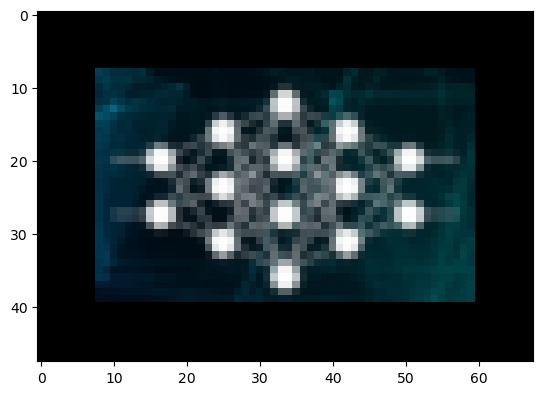

In [24]:
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt
from skimage.transform import resize

cropped = io.imread("target.jpg") / 255.0
cropped = resize(cropped, (72, 72),
                       anti_aliasing=True)
cropped = cropped[20:-20, 10:-10]

cropped = np.pad(cropped, ((8, 8), (8, 8), (0,0)), mode='constant')
plt.imshow(cropped)
print("Image shape:", cropped.shape)
cropped = cropped[np.newaxis, :, :, :]
cropped = tf.convert_to_tensor(cropped, dtype=tf.float32)
#cropped = tf.concat((cropped, tf.ones((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], 1))), axis=2)

### Training

In [6]:
def loss(pred, true):
    return tf.reduce_mean(tf.square(true-pred), axis = [1,2,3])
lr = 2e-3
optimizer = k.optimizers.Adam(lr=lr)

/opt/conda/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Phase 1:

In [10]:
from tqdm import tqdm, trange
from collections import defaultdict
import random

EPOCHS = 501
history = []
SAMPLE_EVERY = 50
BATCH_SIZE = 48
REPLACE_RATE = 0.2
POOL_SIZE = 1024

seed = np.zeros((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
seed[HYPERPARAMS['map_height']//2][HYPERPARAMS['map_width']//2][3:] += 1 # Alive cell in the middle of the image
pool = [[i, -float('inf'), np.copy(seed)] for i in range(POOL_SIZE)]

with trange(EPOCHS) as pbar:
    for epoch in pbar:
        batch = random.sample(pool, BATCH_SIZE)
        grid = tf.convert_to_tensor(np.array([i[2] for i in batch]), dtype=tf.float32)

        if epoch % SAMPLE_EVERY == 0: history.append([grid[:, :, :, :3].numpy()])
        n_backprop_steps = random.randint(HYPERPARAMS['min-backprop-steps'],HYPERPARAMS['max-backprop-steps'])
        n_steps = random.randint(HYPERPARAMS['min-steps'], HYPERPARAMS['max-steps'])
        for ep in range(max(0, n_steps - n_backprop_steps)):
            grid += update_grid_batch(grid)
            #grid = tf.clip_by_value(grid, 0, 1)
            if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())
        with tf.GradientTape() as grad:
            grad.watch(grid); grad.watch(update_model.trainable_variables)
            for ep in range(n_backprop_steps):
                update_batch = update_grid_batch(grid)
                grid = grid + update_batch
                #grid = tf.clip_by_value(grid, 0, 1)
                if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())

            # dGdP = [tf.reduce_sum(tf.stack(grads_per_step[key]), axis=1) for key in grads_per_step]
            grad.watch(cropped)
            L = loss(grid[:, :, :, :4], cropped)
            reduced_loss = tf.reduce_mean(L)
        
        dLdP = grad.gradient(reduced_loss, update_model.trainable_variables)
        batch_losses = L.numpy()
        pool_idxs = [i[0] for i in batch]
        for index, i in enumerate(pool_idxs):
            pool[i][1] = batch_losses[index]
            pool[i][2] = grid[index]
        pool = sorted(pool, key = lambda x: x[1])
        for i in range(1, round(REPLACE_RATE*BATCH_SIZE)+1):
            pool[-i][1] = -float('inf'); pool[-i][2] = np.copy(seed) # Replace highest loss item in the pool with the new seed.
        """
            with tf.GradientTape() as grad:
                grad.watch(grid); grad.watch(cropped)
                L = loss(grid[:,:,:3], cropped)
            dLdG = grad.gradient(L, grid)
        """
        normed_grads = [g/(tf.norm(g)+1e-8) for g in dLdP]
        optimizer.apply_gradients(zip(normed_grads, update_model.trainable_weights))
        
        pbar.set_description("Loss: {0:.5f}".format(reduced_loss.numpy()), refresh = True)

Loss: 0.02456:  25%|█████████████▊                                         | 252/1001 [02:02<06:05,  2.05it/s]


KeyboardInterrupt: 

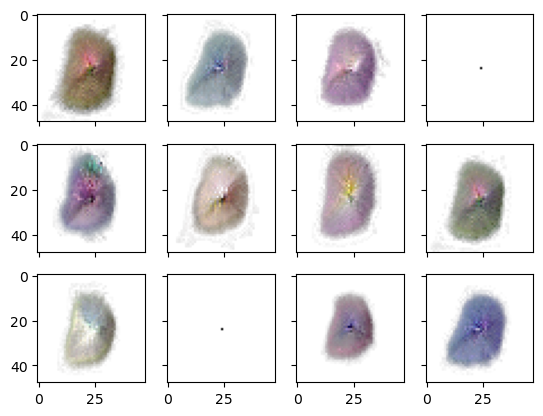

In [11]:
def show_pool(pool):
    fig, axs = plt.subplots(3, 4, sharex = True, sharey = True)
    samples = random.sample(pool, 12)
    for i in range(3):
        for j in range(4):
            axs[i][j].imshow(np.clip(samples[i*4+j][2][:,:,:4], 0, 1))
    fig.show()
show_pool(pool)

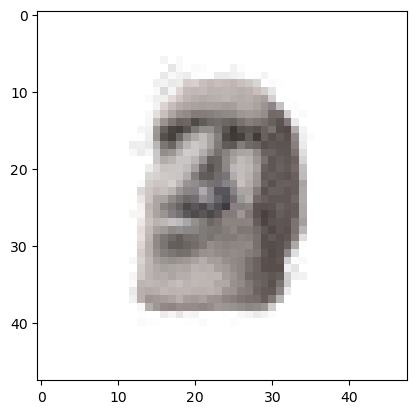

In [36]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video

def generate_animation(episode):
    fig = plt.figure()

    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ims = []
    for slice_ in episode:
        im = plt.imshow(tf.clip_by_value(slice_, 0, 1), animated=True, vmin=0, vmax=1)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    ani.save('dynamic_images.mp4')
    
from tqdm import tqdm, trange
from collections import defaultdict
import random


replay = []
N_REPLAY_STEPS = 200
grid = tf.convert_to_tensor(np.copy(seed), dtype=tf.float32)
replay.append(grid[:, :, :4].numpy())

for ep in range(N_REPLAY_STEPS):
    grid += update_grid(grid)
    #grid = tf.clip_by_value(grid, 0, 1)
    replay.append(grid[:, :, :4].numpy())
    
generate_animation(replay)
Video(filename="dynamic_images.mp4")

In [8]:
update_model.save('./weights/phase1_run4')

INFO:tensorflow:Assets written to: ./weights/phase1_run4/assets


2023-05-06 01:24:16.513183: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


#### Phase 2:

In [72]:
config = optimizer.get_config()
config["learning_rate"] = 2e-4
optimizer = optimizer.from_config(config, custom_objects=None)

In [80]:
seed = np.zeros((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
seed[HYPERPARAMS['map_height']//2][HYPERPARAMS['map_width']//2][3:] += 1 # Alive cell in the middle of the image
pool = [[i, -float('inf'), np.copy(seed)] for i in range(POOL_SIZE)]

In [100]:
from tqdm import tqdm, trange
from collections import defaultdict
import random

EPOCHS = 5001
SAMPLE_EVERY = 50
BATCH_SIZE = 48
REPLACE_RATE = 0.04
POOL_SIZE = 1024
DAMAGE_RATE = 0.5

xx, yy = np.mgrid[:HYPERPARAMS['map_width'], :HYPERPARAMS['map_height']]
# circles contains the squared distance to the (100, 100) point
# we are just using the circle equation learnt at school
max_x = round(HYPERPARAMS['map_width'] * 0.8)
min_x = round(HYPERPARAMS['map_width'] * 0.2)
max_y = round(HYPERPARAMS['map_height'] * 0.8)
min_y = round(HYPERPARAMS['map_height'] * 0.2)

with trange(EPOCHS) as pbar:
    for epoch in pbar:
        batch = random.sample(pool, BATCH_SIZE)
        grid = tf.convert_to_tensor(np.array([i[2] for i in batch]), dtype=tf.float32)

        if epoch % SAMPLE_EVERY == 0: history.append([grid[:, :, :, :3].numpy()])
        n_backprop_steps = random.randint(HYPERPARAMS['min-backprop-steps'],HYPERPARAMS['max-backprop-steps'])
        n_steps = random.randint(HYPERPARAMS['min-steps'], HYPERPARAMS['max-steps'])
        for ep in range(max(0, n_steps - n_backprop_steps)):
            grid += update_grid_batch(grid)
            #grid = tf.clip_by_value(grid, 0, 1)
            if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())
        with tf.GradientTape() as grad:
            grad.watch(grid); grad.watch(update_model.trainable_variables)
            for ep in range(n_backprop_steps):
                update_batch = update_grid_batch(grid)
                grid = grid + update_batch
                #grid = tf.clip_by_value(grid, 0, 1)
                if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())

            # dGdP = [tf.reduce_sum(tf.stack(grads_per_step[key]), axis=1) for key in grads_per_step]
            grad.watch(cropped)
            L = loss(grid[:, :, :, :4], cropped)
            reduced_loss = tf.reduce_mean(L)
        
        dLdP = grad.gradient(reduced_loss, update_model.trainable_variables)
        batch_losses = L.numpy()
        pool_idxs = [i[0] for i in batch]
        for index, i in enumerate(pool_idxs):
            pool[i][1] = batch_losses[index]
            
            if random.random() < DAMAGE_RATE: 
                center_coords = (random.randint(min_x, max_x), random.randint(min_y, max_y))
                radius = random.randint(3, 8)
                circle = ((yy - center_coords[0]) ** 2 + (xx - center_coords[1]) ** 2) < radius**2
                pool[i][2] = grid[index] * (1-circle[:, :, np.newaxis])
                
            else: pool[i][2] = grid[index]
            
        pool = sorted(pool, key = lambda x: x[1])
        for i in range(1, round(REPLACE_RATE*BATCH_SIZE)+1):
            pool[-i][1] = -float('inf'); pool[-i][2] = np.copy(seed) # Replace highest loss item in the pool with the new seed.
        """
            with tf.GradientTape() as grad:
                grad.watch(grid); grad.watch(cropped)
                L = loss(grid[:,:,:3], cropped)
            dLdG = grad.gradient(L, grid)
        """
        normed_grads = [g/(tf.norm(g)+1e-8) for g in dLdP]
        optimizer.apply_gradients(zip(normed_grads, update_model.trainable_weights))
        
        pbar.set_description("Loss: {0:.5f}".format(reduced_loss.numpy()), refresh = True)

Loss: 0.00565: 100%|██████████████████████████████████████████████████████| 5001/5001 [40:53<00:00,  2.04it/s]


In [82]:
ls

dynamic_images.mp4                      LICENSE     README.md   train_log/
Growing_Neural_Cellular_Automata.ipynb  main.ipynb  target.jpg  weights/


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


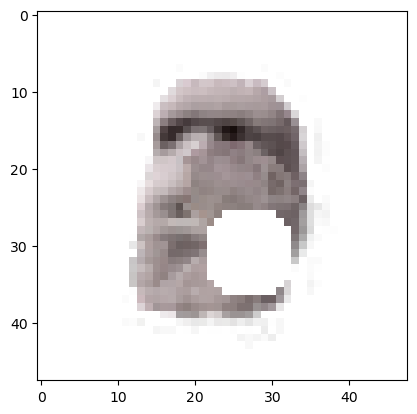

In [101]:
plt.imshow((grid[index] * (1-circle[:, :, np.newaxis]))[:,:,:4])

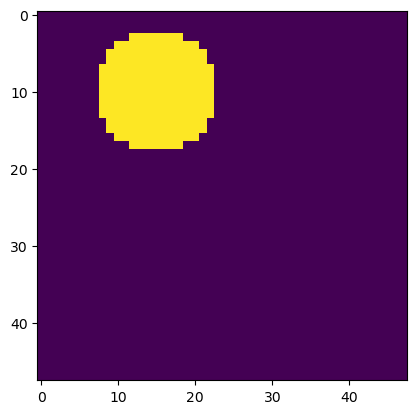

In [34]:
xx, yy = np.mgrid[:HYPERPARAMS['map_width'], :HYPERPARAMS['map_height']]
# circles contains the squared distance to the (100, 100) point
# we are just using the circle equation learnt at school
max_x = round(HYPERPARAMS['map_width'] * 0.8)
min_x = round(HYPERPARAMS['map_width'] * 0.2)
max_y = round(HYPERPARAMS['map_height'] * 0.8)
min_y = round(HYPERPARAMS['map_height'] * 0.2)

center_coords = (random.randint(min_x, max_x), random.randint(min_y, max_y))
radius = random.randint(3, 8)
circle = ((yy - center_coords[0]) ** 2 + (xx - center_coords[1]) ** 2) < radius**2
plt.imshow(circle)

In [31]:
# Loading the model
update_model = models.load_model("./weights/phase4_run4")

In [89]:
update_model.save('./weights/phase4_run4')

INFO:tensorflow:Assets written to: ./weights/phase4_run4/assets


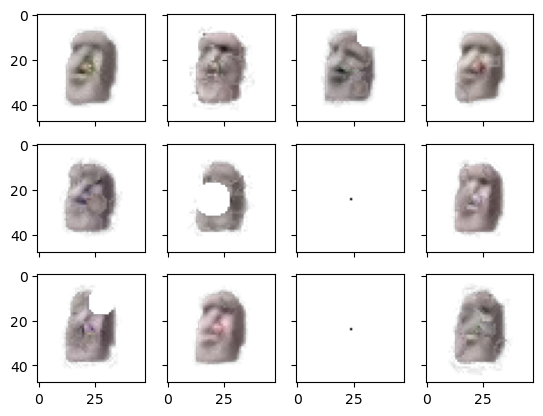

In [102]:
show_pool(pool)

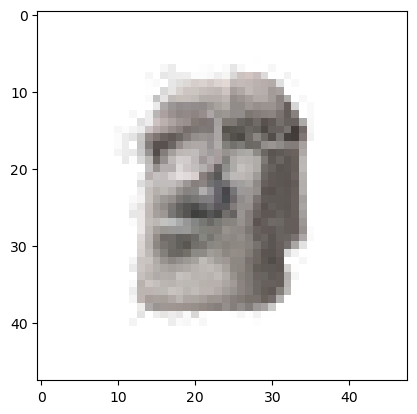

In [37]:
from tqdm import tqdm, trange
from collections import defaultdict
import random

seed = np.zeros((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
seed[HYPERPARAMS['map_height']//2][HYPERPARAMS['map_width']//2][3:] += 1 # Alive cell in the middle of the image

replay = []
N_REPLAY_STEPS = 299
DAMAGE_EVERY = 100
grid = tf.convert_to_tensor(np.copy(seed), dtype=tf.float32)
replay.append(grid[:, :, :4].numpy())

for ep in range(N_REPLAY_STEPS):
    grid += update_grid(grid)
    if (ep + 1) % DAMAGE_EVERY == 0: 
        center_coords = (random.randint(min_x, max_x), random.randint(min_y, max_y))
        radius = random.randint(3, 8)
        circle = ((yy - center_coords[0]) ** 2 + (xx - center_coords[1]) ** 2) < radius**2
        grid *= (1-circle[:, :, np.newaxis])
    #grid = tf.clip_by_value(grid, 0, 1)
    replay.append(grid[:, :, :4].numpy())
    
generate_animation(replay)
Video(filename="dynamic_images.mp4")

In [55]:
config = optimizer.get_config()
config["learning_rate"] = 2e-5
optimizer = optimizer.from_config(config, custom_objects=None)

In [56]:
from tqdm import tqdm, trange
from collections import defaultdict
import random

EPOCHS = 20001
SAMPLE_EVERY = 50
BATCH_SIZE = 48
REPLACE_RATE = 0.05
POOL_SIZE = 1024

with trange(EPOCHS) as pbar:
    for epoch in pbar:
        batch = random.sample(pool, BATCH_SIZE)
        grid = tf.convert_to_tensor(np.array([i[2] for i in batch]), dtype=tf.float32)

        if epoch % SAMPLE_EVERY == 0: history.append([grid[:, :, :, :3].numpy()])
        n_backprop_steps = random.randint(HYPERPARAMS['min-backprop-steps'],HYPERPARAMS['max-backprop-steps'])
        n_steps = random.randint(HYPERPARAMS['min-steps'], HYPERPARAMS['max-steps'])
        for ep in range(max(0, n_steps - n_backprop_steps)):
            grid += update_grid_batch(grid)
            #grid = tf.clip_by_value(grid, 0, 1)
            if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())
        with tf.GradientTape() as grad:
            grad.watch(grid); grad.watch(update_model.trainable_variables)
            for ep in range(n_backprop_steps):
                update_batch = update_grid_batch(grid)
                grid = grid + update_batch
                #grid = tf.clip_by_value(grid, 0, 1)
                if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())

            # dGdP = [tf.reduce_sum(tf.stack(grads_per_step[key]), axis=1) for key in grads_per_step]
            grad.watch(cropped)
            L = loss(grid[:, :, :, :4], cropped)
            reduced_loss = tf.reduce_mean(L)
        
        dLdP = grad.gradient(reduced_loss, update_model.trainable_variables)
        batch_losses = L.numpy()
        pool_idxs = [i[0] for i in batch]
        for index, i in enumerate(pool_idxs):
            pool[i][1] = batch_losses[index]
            pool[i][2] = grid[index]
        pool = sorted(pool, key = lambda x: x[1])
        for i in range(1, round(REPLACE_RATE*BATCH_SIZE)+1):
            pool[-i][1] = -float('inf'); pool[-i][2] = np.copy(seed) # Replace highest loss item in the pool with the new seed.
        """
            with tf.GradientTape() as grad:
                grad.watch(grid); grad.watch(cropped)
                L = loss(grid[:,:,:3], cropped)
            dLdG = grad.gradient(L, grid)
        """
        normed_grads = [g/(tf.norm(g)+1e-8) for g in dLdP]
        optimizer.apply_gradients(zip(normed_grads, update_model.trainable_weights))
        
        pbar.set_description("Loss: {0:.5f}".format(reduced_loss.numpy()), refresh = True)

Loss: 0.00775:   2%|█▏                                                  | 454/20001 [05:04<3:38:51,  1.49it/s]


KeyboardInterrupt: 

In [46]:
update_model.save('./weights/phase3_run4')

INFO:tensorflow:Assets written to: ./weights/phase3_run4/assets


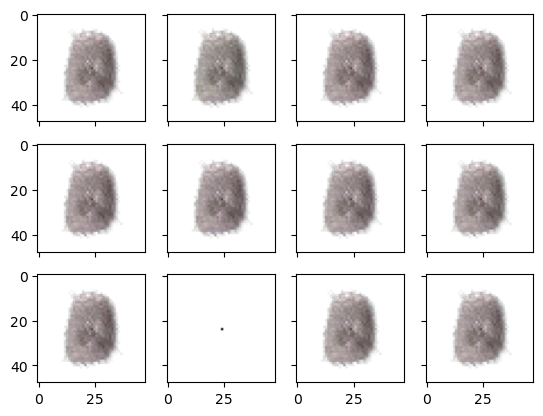

In [52]:
show_pool(pool)

In [15]:
from tqdm import tqdm, trange
from collections import defaultdict

EPOCHS = 5001
SAMPLE_EVERY = 100

with trange(EPOCHS) as pbar:
    for epoch in pbar:
        grid = np.zeros((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
        grid[HYPERPARAMS['map_height']//2][HYPERPARAMS['map_width']//2] += 1 # Alive cell in the middle of the image
        grid = tf.convert_to_tensor(grid, dtype=tf.float32)

        if epoch % SAMPLE_EVERY == 0: history.append([grid[:, :, :3].numpy()])
        n_backprop_steps = random.randint(HYPERPARAMS['min-backprop-steps'],HYPERPARAMS['max-backprop-steps'])
        n_steps = random.randint(HYPERPARAMS['min-steps'], HYPERPARAMS['max-steps'])
        for ep in range(max(0, n_steps - n_backprop_steps)):
            grid += update_grid(grid)
            grid = tf.clip_by_value(grid, 0, 1)
            if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())
        with tf.GradientTape() as grad:
            grad.watch(grid); grad.watch(update_model.trainable_variables)
            for ep in range(n_backprop_steps):
                update_batch = update_grid(grid)
                grid = grid + update_batch
                grid = tf.clip_by_value(grid, 0, 1)
                if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())

            # dGdP = [tf.reduce_sum(tf.stack(grads_per_step[key]), axis=1) for key in grads_per_step]
            grad.watch(cropped)
            L = loss(grid[:, :, :4], cropped)
        dLdP = grad.gradient(L, update_model.trainable_variables)
        """
            with tf.GradientTape() as grad:
                grad.watch(grid); grad.watch(cropped)
                L = loss(grid[:,:,:3], cropped)
            dLdG = grad.gradient(L, grid)
        """
        normed_grads = [g/(tf.norm(g)+1e-8) for g in dLdP]
        optimizer.apply_gradients(zip(normed_grads, update_model.trainable_weights))
        pbar.set_description("Loss: {0:.5f}".format(L.numpy()), refresh = True)

Loss: 0.07178:  30%|████████████████▏                                     | 1499/5001 [23:35<52:02,  1.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [21]:
from tqdm import tqdm, trange
from collections import defaultdict

EPOCHS = 3001
SAMPLE_EVERY = 100

with trange(EPOCHS) as pbar:
    for epoch in pbar:
        grid = np.zeros((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
        grid[HYPERPARAMS['map_height']//2][HYPERPARAMS['map_width']//2] += 1 # Alive cell in the middle of the image
        grid = tf.convert_to_tensor(grid, dtype=tf.float32)

        if epoch % SAMPLE_EVERY == 0: history.append([grid[:, :, :3].numpy()])
        n_backprop_steps = random.randint(HYPERPARAMS['min-backprop-steps'],HYPERPARAMS['max-backprop-steps'])
        n_steps = random.randint(HYPERPARAMS['min-steps'], HYPERPARAMS['max-steps'])
        for ep in range(max(0, n_steps - n_backprop_steps)):
            grid += update_grid(grid)
            grid = tf.clip_by_value(grid, 0, 1)
            if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())
        with tf.GradientTape() as grad:
            grad.watch(grid); grad.watch(update_model.trainable_variables)
            for ep in range(n_backprop_steps):
                update_batch = update_grid(grid)
                grid = grid + update_batch
                grid = tf.clip_by_value(grid, 0, 1)
                if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())

            # dGdP = [tf.reduce_sum(tf.stack(grads_per_step[key]), axis=1) for key in grads_per_step]
            grad.watch(cropped)
            L = loss(grid[:, :, :4], cropped)
        dLdP = grad.gradient(L, update_model.trainable_variables)
        """
            with tf.GradientTape() as grad:
                grad.watch(grid); grad.watch(cropped)
                L = loss(grid[:,:,:3], cropped)
            dLdG = grad.gradient(L, grid)
        """
        normed_grads = [g/(tf.norm(g)+1e-8) for g in dLdP]
        optimizer.apply_gradients(zip(normed_grads, update_model.trainable_weights))
        pbar.set_description("Loss: {0:.5f}".format(L.numpy()), refresh = True)

Loss: 0.37029:  50%|██████████████████████████▉                           | 1499/3001 [25:22<26:27,  1.06s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
update_model.save('./weights/phase3_run3')

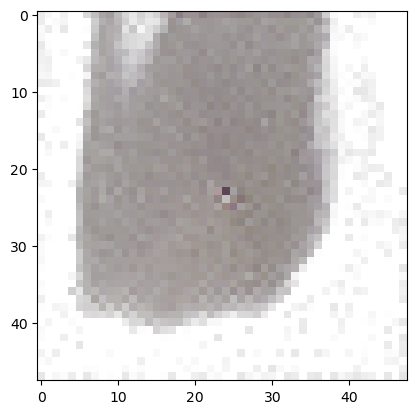

In [16]:
generate_animation(history[-1])
Video(filename="dynamic_images.mp4")